<h1>Course project on Technologies and Infrastructure for Big Data</h1>
<hr></hr>

<b>Project topic:</b> Automating data collection with www.flickr.com database in an image classification problem.

<b>Project executors::</b>

<ul>
    <ol type='1'>
    <li>Medvedev Anatoly Andreevich, ISU 335489.</li>
    <li>Smirnov Ivan Zakharovich, ISU 338330.</li>
    </ol>
</ul>

<a name='000'></a>

<h2>Content</h2>

<ul>
    <ol type='1'>
    <li><a href='#001'>Environment Setup</a></li>
    <li><a href='#002'>Data Parsing</a></li>
    <li><a href='#003'>Data Preprocessing</a></li>
    <li><a href='#004'>Model Training</a></li>
    <li><a href='#005'>Model Validation</a></li>
    </ol>
</ul>

<a name='001'></a>

<h2>Environment Setup</h2>

<a href='#000'>Back to content</a>

To avoid conflicts between framework versions and unwanted warnings, we have executed the script below. This allowed us to at least use `Catalyst` and `PyTorch` frameworks without conflicts in the same environment.

In [1]:
import os
import warnings

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings(action='ignore')

Libraries import. We used `PyTorch` framework to load and fine-tune the pretrained model, `Catalyst` framework to speed up the model training process and `FlickrAPI` to connect to the www.flickr.com database API.

In [2]:
import torch
import torch.nn as nn
import torchvision

from catalyst import dl
import flickrapi
import numpy as np
import pandas as pd
import pylab
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import urllib.request

<a name='002'></a>

<h2>Data Parsing</h2>

<a href='#000'>Back to content</a>

Before we start parsing data, we have received key and secret code to connect to the API. You can get your own key in the Developers section of www.flickr.com or use ours.

In [3]:
API_KEY = '809322371031dd7403805902a5aaddd1'
API_SECRET = '01590df66d97c93d'

We bring to your attention solution to the problem of classifying land transport in 10 categories: `bicycle`, `bus`, `car`, `excavator`, `motorbike`, `scooter`, `snowmobile`, `train`, `truck`, `wagon`. To begin with, we created a directory in which our data set will be located.

In [4]:
labels = ['bicycle', 'bus', 'car', 'excavator', 'motorbike', 'scooter', 'snowmobile', 'train', 'truck', 'wagon']
root = 'dataset'

def create_directory(root, labels):
    os.makedirs(root) if not os.path.exists(root) else 0
    [os.makedirs(os.path.join(root, label)) for label in labels if not os.path.exists(os.path.join(root, label))]
    return os.listdir(root)

The final directory looks like this:
```
dataset/
       |
       bicycle/
       |      |
       |      0.jpg
       |      ...
       bus/
       ...
```

In [5]:
create_directory(root=root, labels=labels)

['bicycle',
 'bus',
 'car',
 'excavator',
 'motorbike',
 'scooter',
 'snowmobile',
 'train',
 'truck',
 'wagon']

We have created two functions. The first one takes an image url as input and uploads it to our directory. The second function sends an API request for each class in our dataset and returns 1500 urls of the most relevant images for our queries.

It is worth paying attention to the arguments of the image search method:
- `text` - keywords in the photo description. For us, these are class names.
- `sort` - flickr's built-in sorting method. We chose sorting by relevance.
- `media` - return data type. For us, it's images.
- `extras` - image metadata. We chose `url_q`, which will return url of the image thumbnail with a size of 150×150, since the original images are not always available for download.
- `per_page` - number of images per query response page.
- `page` - page number of query responses.

In [6]:
def load_image(url, label, index):
    urllib.request.urlretrieve(url, os.path.join(root, label, '{}.jpg'.format(index)))

def parse_flickr(root, label, size=1500):
    api = flickrapi.FlickrAPI(api_key=API_KEY, secret=API_SECRET, format='parsed-json')
    
    print('Downloading photos with label "{}"...'.format(label))
    with tqdm(total=size) as bar:
        index = 0
        for page in range(0, size // 500):
            photos = api.photos.search(text=label, sort='relevance', media='photos',
                extras='url_q', per_page=500, page=page+1)['photos']
            dataframe = pd.DataFrame(data=photos['photo'])
            for url in dataframe['url_q'].tolist():
                load_image(url, label, index)
                index = index + 1
                bar.update(1)
    return label

We have run queries for each of our classes. We have added logging and a progress bar to visualize the process of uploading images.

In [7]:
[parse_flickr(root=root, label=label) for label in labels]

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:27<00:00, 10.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:27<00:00, 10.17it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:29<00:00, 10.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:25<00:00,  7.30it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:27<00:00, 10.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:28<00:00, 10.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:58<00:00,  8.38it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1498/1500 [03:46<00:00,  6.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:40<00:00,  6.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:50<00:00,  6.50it/s]


['bicycle',
 'bus',
 'car',
 'excavator',
 'motorbike',
 'scooter',
 'snowmobile',
 'train',
 'truck',
 'wagon']

<a name='003'></a>

<h2>Data Preprocessing</h2>

<a href='#000'>Back to content</a>

Before starting to train the model, we have preprocessed the data.

We used `ResNet-18` model pre-trained on the ImageNet dataset. In order to increase the efficiency of training, we used augmentation close to ImageNet. We applied image resizing to 224×224 size and normalization of pixel intensity values. The size of the training and test samples were 75% and 25% of the total set, respectively.

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root=root, transform=transforms)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, shuffle=True)

In [7]:
loaders = {
    'train': torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32),
    'valid': torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32),
}

We have packed datasets into batches, each with 32 pairs (image, label). Visualization of the first batch of the training set is shown below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wagon wagon snowmobile truck snowmobile excavator bicycle snowmobile car wagon truck truck train scooter scooter scooter car bus bus bicycle train truck bus excavator motorbike wagon bicycle snowmobile car motorbike train motorbike


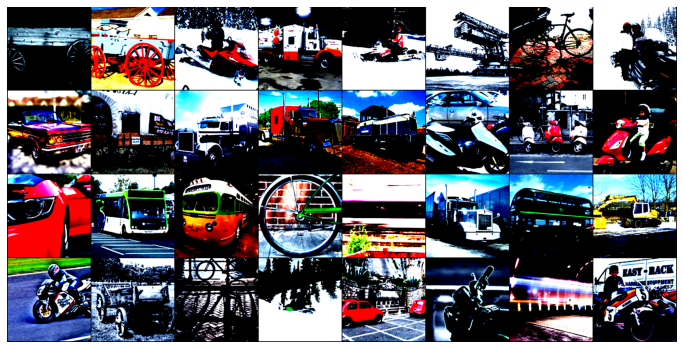

In [8]:
def plot_dataloader(dataloader):
    images, targets = dataloader
    images = torchvision.utils.make_grid(images).numpy()
    
    print(' '.join(f'{labels[targets[i]]}' for i in range(32)))
    pylab.figure(figsize=(12, 12))
    pylab.imshow(np.transpose(images, axes=(1, 2, 0)))
    pylab.axis('off')
    pylab.show()

plot_dataloader(next(iter(loaders['train'])))

<a name='004'></a>

<h2>Model Training</h2>

<a href='#000'>Back to content</a>

We used `ResNet-18` model pre-trained on the ImageNet dataset. To work with it, we frozed model layers, except for the batch normalization and the last two convolutional layers. This allowed us to use the experience of ImageNet training and at the same time to teach model to find high-frequency features on our images. The output of our model is 10 neurons.

In [9]:
def resnet18(pretrained=True):
    model = torchvision.models.resnet18(pretrained=pretrained)
    
    for name, parameter in model.named_parameters():
        if('bn' not in name):
            parameter.requires_grad = False
    
    # Freeze all convolution layers except the last two.
    unfrozen_layers = [model.layer3, model.layer4]
    for layer in unfrozen_layers:
        for parameter in layer.parameters():
            parameter.requires_grad = True
    
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 500),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(500, 10)
    )
    
    return model

We chose Cross Entropy as the loss function, and RMSprop algorithm as the optimizer.

In [10]:
model = resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.02)

Using `Catalyst` framework, we trained the model for 25 epochs. Logging of the model prediction accuracy and losses after each epoch on the training and tets samples is shown below.

In [11]:
runner = dl.SupervisedRunner(
    input_key='features', output_key='logits', target_key='targets', loss_key='loss'
)

In [12]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=25,
    callbacks=[dl.AccuracyCallback(input_key='logits', target_key='targets')],
    logdir='./logs',
    valid_loader='valid',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
)

1/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (1/25) accuracy01: 0.13317923186344238 | accuracy01/std: 0.06608789668906749 | loss: 12.579858020393129 | loss/mean: 12.579858020393129 | loss/std: 87.76704187395727 | lr: 0.02 | momentum: 0.0


1/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (1/25) accuracy01: 0.1901333333412807 | accuracy01/std: 0.073904554450128 | loss: 2.222076872889201 | loss/mean: 2.222076872889201 | loss/std: 0.153951886366464 | lr: 0.02 | momentum: 0.0
* Epoch (1/25) 


2/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (2/25) accuracy01: 0.2481330014224751 | accuracy01/std: 0.08423555856068811 | loss: 2.0351007995361288 | loss/mean: 2.0351007995361288 | loss/std: 0.18712774345081623 | lr: 0.02 | momentum: 0.0


2/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (2/25) accuracy01: 0.3282666666825611 | accuracy01/std: 0.07934388521320715 | loss: 1.8156734563827517 | loss/mean: 1.8156734563827517 | loss/std: 0.18532630787772988 | lr: 0.02 | momentum: 0.0
* Epoch (2/25) 


3/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (3/25) accuracy01: 0.3751778093883357 | accuracy01/std: 0.10034600245233616 | loss: 2.043199477629846 | loss/mean: 2.043199477629846 | loss/std: 6.890114997993918 | lr: 0.02 | momentum: 0.0


3/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (3/25) accuracy01: 0.3229333333492279 | accuracy01/std: 0.07450942071087736 | loss: 2.425338039461772 | loss/mean: 2.425338039461772 | loss/std: 0.5374449088757244 | lr: 0.02 | momentum: 0.0
* Epoch (3/25) 


4/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (4/25) accuracy01: 0.4492354196301563 | accuracy01/std: 0.10204069406905275 | loss: 1.4494375026073443 | loss/mean: 1.4494375026073443 | loss/std: 0.24887360346865156 | lr: 0.02 | momentum: 0.0


4/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (4/25) accuracy01: 0.5429333333492278 | accuracy01/std: 0.0957616071438744 | loss: 1.1956728291193646 | loss/mean: 1.1956728291193646 | loss/std: 0.20080886160095995 | lr: 0.02 | momentum: 0.0
* Epoch (4/25) 


5/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (5/25) accuracy01: 0.568100995732575 | accuracy01/std: 0.096919355871421 | loss: 1.1638256904919482 | loss/mean: 1.1638256904919482 | loss/std: 0.230931858296409 | lr: 0.02 | momentum: 0.0


5/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (5/25) accuracy01: 0.5421333333333334 | accuracy01/std: 0.08771260165460433 | loss: 1.341547953446707 | loss/mean: 1.341547953446707 | loss/std: 0.2817455483077298 | lr: 0.02 | momentum: 0.0
* Epoch (5/25) 


6/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (6/25) accuracy01: 0.6203769559032715 | accuracy01/std: 0.09191055766162573 | loss: 1.041002565223835 | loss/mean: 1.041002565223835 | loss/std: 0.2526304269906756 | lr: 0.02 | momentum: 0.0


6/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (6/25) accuracy01: 0.6330666666666662 | accuracy01/std: 0.0842822034566457 | loss: 1.0722992117563885 | loss/mean: 1.0722992117563885 | loss/std: 0.26958880597271745 | lr: 0.02 | momentum: 0.0
* Epoch (6/25) 


7/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (7/25) accuracy01: 0.6663406827880518 | accuracy01/std: 0.08868805717821152 | loss: 0.9158718000095908 | loss/mean: 0.9158718000095908 | loss/std: 0.23940029797466142 | lr: 0.02 | momentum: 0.0


7/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (7/25) accuracy01: 0.6408000000317894 | accuracy01/std: 0.08744623264831655 | loss: 0.9261363910039268 | loss/mean: 0.9261363910039268 | loss/std: 0.22814388670090335 | lr: 0.02 | momentum: 0.0
* Epoch (7/25) 


8/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (8/25) accuracy01: 0.7227062588904695 | accuracy01/std: 0.0852539350305577 | loss: 0.7953396231826297 | loss/mean: 0.7953396231826297 | loss/std: 0.24793554476678692 | lr: 0.02 | momentum: 0.0


8/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (8/25) accuracy01: 0.7965333333333332 | accuracy01/std: 0.07524067072510629 | loss: 0.6121093720356627 | loss/mean: 0.6121093720356627 | loss/std: 0.2348145201610949 | lr: 0.02 | momentum: 0.0
* Epoch (8/25) 


9/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (9/25) accuracy01: 0.7604018492176386 | accuracy01/std: 0.08402600906975137 | loss: 0.7008826312520263 | loss/mean: 0.7008826312520263 | loss/std: 0.2400681574573412 | lr: 0.02 | momentum: 0.0


9/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (9/25) accuracy01: 0.738133333396912 | accuracy01/std: 0.07903770746438457 | loss: 0.9305979567209879 | loss/mean: 0.9305979567209879 | loss/std: 0.3327832048247421 | lr: 0.02 | momentum: 0.0
* Epoch (9/25) 


10/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (10/25) accuracy01: 0.7917852062588903 | accuracy01/std: 0.07505722487651371 | loss: 0.6139339371604227 | loss/mean: 0.6139339371604227 | loss/std: 0.21931202503353264 | lr: 0.02 | momentum: 0.0


10/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (10/25) accuracy01: 0.7424000000000001 | accuracy01/std: 0.08800173377859936 | loss: 0.9283423847158748 | loss/mean: 0.9283423847158748 | loss/std: 0.38357356479173516 | lr: 0.02 | momentum: 0.0
* Epoch (10/25) 


11/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (11/25) accuracy01: 0.8160561877667142 | accuracy01/std: 0.07374826184480213 | loss: 0.5537998640901847 | loss/mean: 0.5537998640901847 | loss/std: 0.2328817113733462 | lr: 0.02 | momentum: 0.0


11/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (11/25) accuracy01: 0.7925333333651227 | accuracy01/std: 0.0717871917468847 | loss: 0.6779242655118304 | loss/mean: 0.6779242655118304 | loss/std: 0.2524039279989611 | lr: 0.02 | momentum: 0.0
* Epoch (11/25) 


12/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (12/25) accuracy01: 0.8404160739687053 | accuracy01/std: 0.06633085564622827 | loss: 0.48834566608770813 | loss/mean: 0.48834566608770813 | loss/std: 0.2109997475607262 | lr: 0.02 | momentum: 0.0


12/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (12/25) accuracy01: 0.8178666666666666 | accuracy01/std: 0.07213762249092488 | loss: 0.6028761272857589 | loss/mean: 0.6028761272857589 | loss/std: 0.27701170862315766 | lr: 0.02 | momentum: 0.0
* Epoch (12/25) 


13/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (13/25) accuracy01: 0.8415718349928873 | accuracy01/std: 0.0723474409677016 | loss: 0.5019941269863892 | loss/mean: 0.5019941269863892 | loss/std: 0.2968256764921719 | lr: 0.02 | momentum: 0.0


13/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (13/25) accuracy01: 0.8042666666666667 | accuracy01/std: 0.07040206395448435 | loss: 0.696624617748459 | loss/mean: 0.696624617748459 | loss/std: 0.2962022933826057 | lr: 0.02 | momentum: 0.0
* Epoch (13/25) 


14/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (14/25) accuracy01: 0.8650426742532004 | accuracy01/std: 0.06492982684823988 | loss: 0.4167155039577533 | loss/mean: 0.4167155039577533 | loss/std: 0.19584862816144102 | lr: 0.02 | momentum: 0.0


14/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (14/25) accuracy01: 0.8234666666666668 | accuracy01/std: 0.06990912314108307 | loss: 0.6986942508985601 | loss/mean: 0.6986942508985601 | loss/std: 0.3505298216219863 | lr: 0.02 | momentum: 0.0
* Epoch (14/25) 


15/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (15/25) accuracy01: 0.8767780938833576 | accuracy01/std: 0.06158160981356154 | loss: 0.38572598226463833 | loss/mean: 0.38572598226463833 | loss/std: 0.22207311927411383 | lr: 0.02 | momentum: 0.0


15/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (15/25) accuracy01: 0.7890666666666665 | accuracy01/std: 0.06892069528682399 | loss: 1.0237193454901377 | loss/mean: 1.0237193454901377 | loss/std: 0.43936974277321045 | lr: 0.02 | momentum: 0.0
* Epoch (15/25) 


16/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (16/25) accuracy01: 0.8932254623044099 | accuracy01/std: 0.056929588605787555 | loss: 0.33193158927462296 | loss/mean: 0.33193158927462296 | loss/std: 0.1815803301679663 | lr: 0.02 | momentum: 0.0


16/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (16/25) accuracy01: 0.5714666666666667 | accuracy01/std: 0.08560258740062013 | loss: 4.444136523437501 | loss/mean: 4.444136523437501 | loss/std: 1.6358596708008295 | lr: 0.02 | momentum: 0.0
* Epoch (16/25) 


17/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (17/25) accuracy01: 0.8933143669985777 | accuracy01/std: 0.06086477102513503 | loss: 0.3419484251786874 | loss/mean: 0.3419484251786874 | loss/std: 0.21157531521860082 | lr: 0.02 | momentum: 0.0


17/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (17/25) accuracy01: 0.8285333333333337 | accuracy01/std: 0.06677353175797879 | loss: 0.7482953904509545 | loss/mean: 0.7482953904509545 | loss/std: 0.3516939172148262 | lr: 0.02 | momentum: 0.0
* Epoch (17/25) 


18/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (18/25) accuracy01: 0.9094061166429587 | accuracy01/std: 0.05540781568398413 | loss: 0.2997823642940391 | loss/mean: 0.2997823642940391 | loss/std: 0.25710193557799416 | lr: 0.02 | momentum: 0.0


18/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (18/25) accuracy01: 0.8266666666666664 | accuracy01/std: 0.06836277115860419 | loss: 0.9216278512212137 | loss/mean: 0.9216278512212137 | loss/std: 0.4907601908049114 | lr: 0.02 | momentum: 0.0
* Epoch (18/25) 


19/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (19/25) accuracy01: 0.9101173541963009 | accuracy01/std: 0.05473177569385093 | loss: 0.29382160122096995 | loss/mean: 0.29382160122096995 | loss/std: 0.2155693472330892 | lr: 0.02 | momentum: 0.0


19/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (19/25) accuracy01: 0.8282666666666667 | accuracy01/std: 0.0752274639648188 | loss: 0.7938807381724319 | loss/mean: 0.7938807381724319 | loss/std: 0.47077376972512613 | lr: 0.02 | momentum: 0.0
* Epoch (19/25) 


20/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (20/25) accuracy01: 0.9201635846372686 | accuracy01/std: 0.051100974492164525 | loss: 0.2592314382800421 | loss/mean: 0.2592314382800421 | loss/std: 0.19608928930993905 | lr: 0.02 | momentum: 0.0


20/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (20/25) accuracy01: 0.8247999999999998 | accuracy01/std: 0.07010423592317253 | loss: 0.8422866112232208 | loss/mean: 0.8422866112232208 | loss/std: 0.4559458959449436 | lr: 0.02 | momentum: 0.0
* Epoch (20/25) 


21/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (21/25) accuracy01: 0.9189189189189184 | accuracy01/std: 0.047956882153953315 | loss: 0.290344047949651 | loss/mean: 0.290344047949651 | loss/std: 0.2663896785192708 | lr: 0.02 | momentum: 0.0


21/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (21/25) accuracy01: 0.818933333333333 | accuracy01/std: 0.06601280890710663 | loss: 1.3357395617321135 | loss/mean: 1.3357395617321135 | loss/std: 0.8594872794757197 | lr: 0.02 | momentum: 0.0
* Epoch (21/25) 


22/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (22/25) accuracy01: 0.9332325746799429 | accuracy01/std: 0.053012446792706336 | loss: 0.21987280354915917 | loss/mean: 0.21987280354915917 | loss/std: 0.17890889224392467 | lr: 0.02 | momentum: 0.0


22/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (22/25) accuracy01: 0.8186666666666667 | accuracy01/std: 0.07236218094845759 | loss: 1.0944415620308907 | loss/mean: 1.0944415620308907 | loss/std: 0.6708011486787243 | lr: 0.02 | momentum: 0.0
* Epoch (22/25) 


23/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (23/25) accuracy01: 0.930921052631579 | accuracy01/std: 0.048063696858420345 | loss: 0.2591440448461955 | loss/mean: 0.2591440448461955 | loss/std: 0.2655998253341177 | lr: 0.02 | momentum: 0.0


23/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (23/25) accuracy01: 0.8093333333333332 | accuracy01/std: 0.07920160979563914 | loss: 1.390493610644116 | loss/mean: 1.390493610644116 | loss/std: 0.8022603152687685 | lr: 0.02 | momentum: 0.0
* Epoch (23/25) 


24/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (24/25) accuracy01: 0.9279871977240399 | accuracy01/std: 0.05445979374333653 | loss: 0.30044082824040086 | loss/mean: 0.30044082824040086 | loss/std: 0.5924255758223863 | lr: 0.02 | momentum: 0.0


24/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (24/25) accuracy01: 0.8466666666666666 | accuracy01/std: 0.06768882745957651 | loss: 0.7477265578508375 | loss/mean: 0.7477265578508375 | loss/std: 0.4401114732299158 | lr: 0.02 | momentum: 0.0
* Epoch (24/25) 


25/25 * Epoch (train):   0%|          | 0/352 [00:00<?, ?it/s]

train (25/25) accuracy01: 0.9402560455192027 | accuracy01/std: 0.04750680257982127 | loss: 0.20499468814571042 | loss/mean: 0.20499468814571042 | loss/std: 0.20868365069196004 | lr: 0.02 | momentum: 0.0


25/25 * Epoch (valid):   0%|          | 0/118 [00:00<?, ?it/s]

valid (25/25) accuracy01: 0.7656000000635781 | accuracy01/std: 0.08487052052661381 | loss: 2.0332270965894073 | loss/mean: 2.0332270965894073 | loss/std: 1.0522648814820559 | lr: 0.02 | momentum: 0.0
* Epoch (25/25) 
Top models:
./logs\checkpoints/model.0012.pth	0.6029


<a name='005'></a>

<h2>Model Validation</h2>

<a href='#000'>Back to content</a>

We validated model on the first batch of the test set and visualized prediction of the model. The final accuracy of the model after 25 training epochs was `92.8%` on the training set and `84.7%` on the test one.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target:
scooter excavator car train bus motorbike snowmobile motorbike bus excavator scooter scooter scooter snowmobile bicycle truck train motorbike snowmobile excavator bus train scooter bicycle truck bus wagon excavator truck motorbike excavator excavator


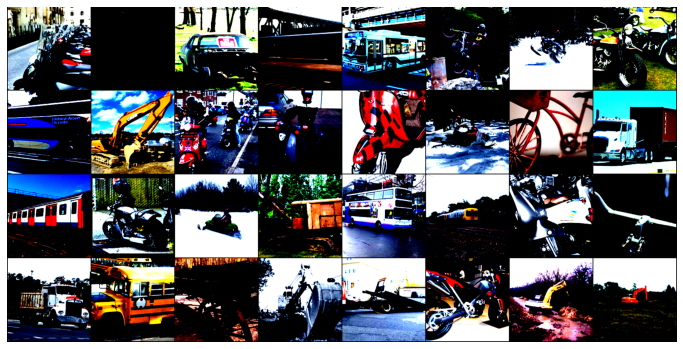

Prediction:
motorbike excavator car train bus motorbike snowmobile motorbike car excavator scooter scooter scooter snowmobile bicycle truck train motorbike snowmobile train bus train motorbike car truck truck wagon excavator truck motorbike excavator excavator


In [30]:
valid_loader = next(iter(loaders['valid']))
print('Target:')
plot_dataloader(valid_loader)

for prediction in runner.predict_loader(loader=loaders['valid']):
    print('Prediction:')
    logits = prediction['logits'].detach().cpu().numpy().argmax(axis=1)
    print(' '.join(f'{labels[logits[i]]}' for i in range(32)))
    break

Plots of model prediction accuracy and model loss on the test set during training are shown below.

In [38]:
def plot_metric(acc, loss):
    figure, ax = pylab.subplots(1, 2, figsize=(20, 5))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    ax[0] = sns.lineplot(data=acc, ax=ax[0])
    ax[0].set(xlabel='Epoch')
    ax[0].set(ylabel='Value')
    ax[0].set_title('Test Accuracy')
    
    ax[1] = sns.lineplot(data=loss, ax=ax[1])
    ax[1].set(xlabel='Epoch')
    ax[1].set(ylabel='Value')
    ax[1].set_title('Test Loss')
    
    pylab.show()

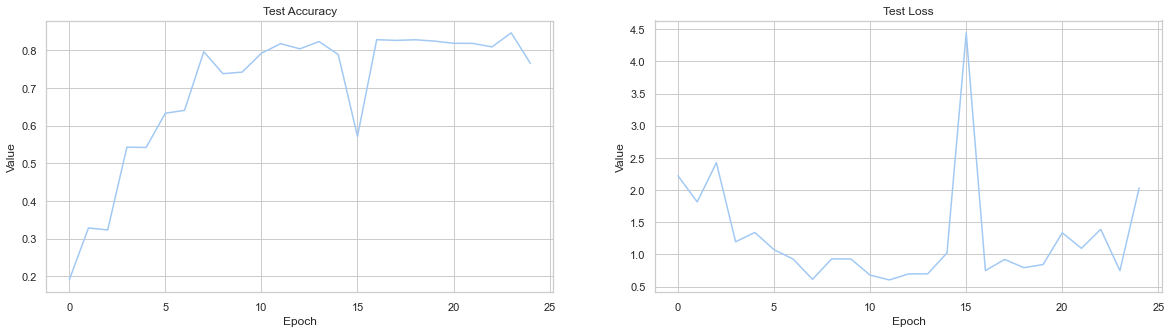

In [40]:
dataframe = pd.read_csv('./logs/csv_logger/valid.csv')
plot_metric(acc=dataframe['accuracy01'], loss=dataframe['loss'])